In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [2]:
# Get data from Yahoo finance
df = yf.download('GLD', start='2020-01-01')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,143.860001,144.210007,143.399994,143.949997,143.949997,7733800
2020-01-03,145.750000,146.320007,145.399994,145.860001,145.860001,12272800
2020-01-06,148.440002,148.479996,146.949997,147.389999,147.389999,14403300
2020-01-07,147.570007,148.139999,147.429993,147.970001,147.970001,7978500
2020-01-08,148.490005,148.610001,146.139999,146.860001,146.860001,22248500


In [3]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 926 entries, 2020-01-02 to 2023-09-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       926 non-null    float64
 1   High       926 non-null    float64
 2   Low        926 non-null    float64
 3   Close      926 non-null    float64
 4   Adj Close  926 non-null    float64
 5   Volume     926 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 50.6 KB


In [4]:
# Log Close
df['Log_Close'] = np.log(df['Close'])

In [5]:
# Compute the first difference of Log_Close
df['Diff_Log_Close'] = df['Log_Close'].diff()

In [6]:
# Split data into train and test
Ntest = 10
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [7]:
# Standardize the Time Series
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['Diff_Log_Close']])
test_scaled = scaler.fit_transform(test[['Diff_Log_Close']])

In [8]:
# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [9]:
# Put the Scaled Log Return back to dataframe use the column name 'Scaled_Log_Ret'
# We use flatten function because Scikit-Learn returns 2D arrays
df.loc[train_idx, 'Scaled_Log_Ret'] = train_scaled.flatten()
df.loc[test_idx, 'Scaled_Log_Ret'] = test_scaled.flatten()

In [10]:
# Make Supervised Dataset
series = df['Scaled_Log_Ret'].dropna().to_numpy()
T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t: t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)

print('X Shape: ', X.shape, 'Y Shape: ', Y.shape)

X Shape:  (915, 10) Y Shape:  (915,)


In [11]:
# Split our supervised dataset into train and test
Xtrain, Xtest = X[:-Ntest], X[-Ntest:]
Ytrain, Ytest = Y[:-Ntest], Y[-Ntest:]

In [12]:
# Create our ANN Model
model = Sequential()
model.add(Dense(10, activation="relu", input_shape=(T,)))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))

In [13]:
# Call Compile Function
model.compile(loss='mse', optimizer='adam', metrics='mae')

In [14]:
# Call Fit Function
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

Epoch 1/100
29/29 [==============================] - 1s 10ms/step - loss: 2.3494 - mae: 1.1537 - val_loss: 1.3748 - val_mae: 0.9659
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6756 - mae: 0.9614 - val_loss: 1.2431 - val_mae: 0.9007
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 1.3737 - mae: 0.8640 - val_loss: 1.1817 - val_mae: 0.8607
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.2330 - mae: 0.8153 - val_loss: 1.1484 - val_mae: 0.8488
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1485 - mae: 0.7867 - val_loss: 1.1286 - val_mae: 0.8384
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1010 - mae: 0.7701 - val_loss: 1.1155 - val_mae: 0.8285
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0714 - mae: 0.7585 - val_loss: 1.1017 - val_mae: 0.8194
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0509 - 

In [15]:
# History's Keys
r.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

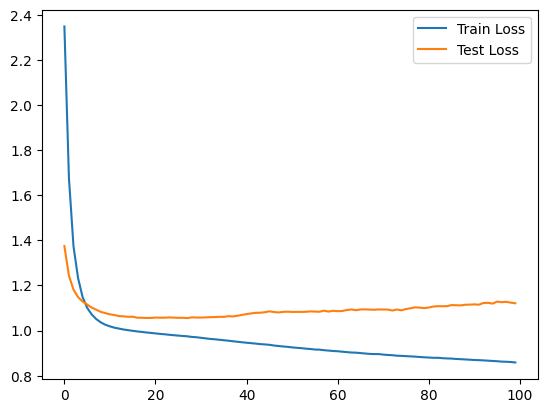

In [16]:
# Plot
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Test Loss')
plt.legend();

In [17]:
# First T values are not predictable
train_idx[:T+1] = False

In [18]:
# Make Prediction
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
# Invert the Scaling
Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

1/1 [==============================] - 0s 57ms/step


In [19]:
# Store Diff Predictions
df.loc[train_idx, 'Diff_ANN_Train_Pred'] = Ptrain
df.loc[test_idx, 'Diff_ANN_Test_Pred'] = Ptest

In [20]:
# Plot
px.line(df, x=df.index, y=['Diff_Log_Close', 'Diff_ANN_Train_Pred', 'Diff_ANN_Test_Pred'])

In [21]:
# Shifted Log Close values will use to Compute Un-Differenced Predictions
df['Shifted_Log_Close'] = df['Log_Close'].shift(1)
prev = df['Shifted_Log_Close']

In [22]:
# 1 step forecast
df.loc[train_idx, '1_Step_pred_Train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1_Step_pred_Test'] = prev[test_idx] + Ptest

In [23]:
# Plot 1-Step Forecast
px.line(df, x=df.index, y=['Log_Close', '1_Step_pred_Train', '1_Step_pred_Test'])

In [24]:
# Multi-Step Forecast
multistep_predictions = []

In [25]:
# First test input
last_x = Xtrain[-1]

In [26]:
# We have to call reshape method because Tensoreflow only uses 2D array
while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1,-1))[0] # [0] Returns just a number otherwise we'll have a bunch of array.
  # Update the predictions list
  multistep_predictions.append(p)
  # Make the new input
  last_x = np.roll(last_x, -1) # Roll function spins our list 1 unit.
  last_x[-1] = p # P value will replace with last value of our list.

multistep_predictions

1/1 [==============================] - 0s 47ms/step


[array([-0.16434719], dtype=float32),
 array([-0.21682703], dtype=float32),
 array([-0.21110743], dtype=float32),
 array([-0.20005798], dtype=float32),
 array([-0.22097823], dtype=float32),
 array([-0.13767633], dtype=float32),
 array([-0.24668516], dtype=float32),
 array([-0.17229104], dtype=float32),
 array([-0.21398926], dtype=float32),
 array([-0.2037724], dtype=float32)]

In [27]:
# Invert the Scaling
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1,1)).flatten() # reshape because required for scikit-learn

In [28]:
# Last-Known train value
last_train = train.iloc[-1]['Log_Close']

In [29]:
# Save multi-step forecast to dataframe
df.loc[test_idx, 'Multi_Step'] = last_train + np.cumsum(multistep_predictions)

In [30]:
# Plot 1-Step and Molti-Step Forecast
px.line(df, x=df.index, y=['Log_Close', '1_Step_pred_Test', 'Multi_Step'])

In [31]:
# Make Multi-Output Supervised Dataset
Tx = T # Tx represent the number of time steps in the input
Ty = Ntest # Ty represent the number of time steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t: t+Tx]
  X.append(x)
  y = series[t+Tx: t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

print('X shape: ', X.shape, 'Y shape: ', Y.shape)

X shape:  (906, 10) Y shape:  (906, 10)


In [32]:
# Split data into train and test
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [33]:
# Create our ANN Model
model = Sequential()
model.add(Dense(10, activation="relu", input_shape=(Tx,)))
model.add(Dense(10, activation="relu"))
model.add(Dense(Ty))

In [34]:
# Call Compile Function
model.compile(loss='mse', optimizer='adam', metrics='mae')

In [35]:
# Call Fit Function
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

Epoch 1/100
29/29 [==============================] - 2s 20ms/step - loss: 1.1529 - mae: 0.7855 - val_loss: 1.0234 - val_mae: 0.7956
Epoch 2/100
29/29 [==============================] - 0s 9ms/step - loss: 1.0913 - mae: 0.7640 - val_loss: 1.0005 - val_mae: 0.7860
Epoch 3/100
29/29 [==============================] - 0s 8ms/step - loss: 1.0600 - mae: 0.7520 - val_loss: 0.9909 - val_mae: 0.7811
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 1.0427 - mae: 0.7456 - val_loss: 0.9876 - val_mae: 0.7796
Epoch 5/100
29/29 [==============================] - 0s 13ms/step - loss: 1.0308 - mae: 0.7411 - val_loss: 0.9856 - val_mae: 0.7797
Epoch 6/100
29/29 [==============================] - 0s 11ms/step - loss: 1.0234 - mae: 0.7387 - val_loss: 0.9850 - val_mae: 0.7804
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 1.0174 - mae: 0.7366 - val_loss: 0.9868 - val_mae: 0.7822
Epoch 8/100
29/29 [==============================] - 0s 16ms/step - loss: 1.013

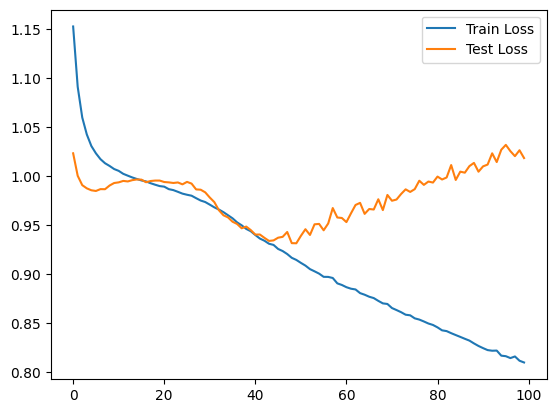

In [36]:
# Plot
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Test Loss')
plt.legend();

In [37]:
# Make Prediction
# Note that we do not flatten() the prediction
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 22ms/step


In [38]:
# Shape
Ptrain.shape, Ptest.shape

((905, 10), (1, 10))

In [39]:
# Index our prediction
Ptrain = Ptrain[:, 0]
Ptest = Ptest[0]

In [40]:
# Unscale
Ptest = scaler.inverse_transform(Ptest.reshape(-1,1)).flatten()

In [41]:
# Save Multi-Step Forecast to DataFrame
df.loc[test_idx, 'Multi_OutPut'] = last_train + np.cumsum(Ptest)

In [42]:
# Plot all Forecasts
px.line(df, x=df.index, y=['Log_Close', '1_Step_pred_Test', 'Multi_Step', 'Multi_OutPut'])

In [43]:
# MAPE
test_log_Close = df.iloc[-Ntest:]['Log_Close']
mape_1 = mean_absolute_percentage_error(test_log_Close, df.loc[test_idx, '1_Step_pred_Test'])
print('1Step MAPE: ', mape_1)
mape_2 = mean_absolute_percentage_error(test_log_Close, df.loc[test_idx, 'Multi_Step'])
print('Multi-Step MAPE: ', mape_2)
mape_3 = mean_absolute_percentage_error(test_log_Close, df.loc[test_idx, 'Multi_OutPut'])
print('Multi-OutPut MAPE: ', mape_3)

1Step MAPE:  0.0008049072347655735
Multi-Step MAPE:  0.003055667779538666
Multi-OutPut MAPE:  0.0023192038988838334


In [44]:
# R2 Score
test_log_Close = df.iloc[-Ntest:]['Log_Close']
R2_1 = r2_score(test_log_Close, df.loc[test_idx, '1_Step_pred_Test'])
print('1Step R2: ', R2_1)
R2_2 = r2_score(test_log_Close, df.loc[test_idx, 'Multi_Step'])
print('Multi-Step R2: ', R2_2)
R2_3 = r2_score(test_log_Close, df.loc[test_idx, 'Multi_OutPut'])
print('Multi-OutPut R2: ', R2_3)

1Step R2:  0.0556223175649897
Multi-Step R2:  -7.235918016366789
Multi-OutPut R2:  -4.005731934961932
